<a href="https://colab.research.google.com/github/fafnerzhang/data-course-sample/blob/dev/week_3/item_based_collaborative_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [2]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-09 12:24:14--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  10.2MB/s    in 1.5s    

2022-01-09 12:24:16 (10.2 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2022-01-09 12:24:16--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  7.56MB/s    in 1.3s    

202

In [4]:
metadata = getDF('./meta_All_Beauty.json.gz')
ratings = pd.read_csv('./All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [5]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [6]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [7]:
import regex as re
from string import digits

def remove_brand(text):
    res = re.sub(brand_pattern, '', text)
    return res

def find_brand(text):
    res = re.match(brand_pattern, text)
    return res.group(0) if res else ''

def extract_price(cell):
    cell = ''.join(c for c in cell if c in digits)
    return int(cell) if len(cell) > 0 else 0
    

ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
brand_list = metadata['brand'].value_counts().keys().tolist()
brand_list = list(filter(lambda x:len(x)>2, brand_list))
metadata['text_data'] = metadata.agg(lambda x: f'{x["title"]}, {" ".join(x["description"])}', axis=1)
brand_pattern = re.compile(r"(?:{})".format('|'.join([re.escape(x) for x in brand_list])))
metadata['brand_from_title'] = metadata['title'].apply(find_brand)
metadata['price'] = metadata['price'].apply(extract_price)
metadata['sub_category'] = metadata['rank'].str.split('in ').str[1]
metadata['sub_category'] = metadata['sub_category'].str.replace(r'&amp;', '', regex=True)
metadata['sub_category'] = metadata['sub_category'].str.replace(r'\(', '', regex=True)
metadata['sub_category'] = metadata['sub_category'].str.replace(r'&', '', regex=True)
# metadata['title_without_brand'] = metadata['title'].apply(remove_brand)
# metadata['text_data'] = metadata['text_data'].apply(remove_brand)

In [8]:
metadata['sub_category'].value_counts()

Beauty  Personal Care        32380
Grocery  Gourmet Food           38
Health  Household               21
Sports  Outdoors                 3
Toys  Games                      3
Clothing, Shoes  Jewelry         2
Baby                             2
Home  Kitchen                    1
Automotive                       1
Tools  Home Improvement          1
Name: sub_category, dtype: int64

In [9]:
metadata.drop(metadata[(metadata['sub_category'] != 'BeautyPersonalCare')].index)
metadata_processed = metadata.drop_duplicates(subset=['title', 'asin'], keep=False)
metadata_processed = metadata_processed.drop(['category', 'fit', 'tech1', 'tech2', 'description', 'feature', 'details', 'imageURL', 'imageURLHighRes', 'similar_item'], axis=1)
metadata_processed = metadata_processed.drop_duplicates('title')
metadata_processed = metadata_processed.drop_duplicates('asin')
metadata_processed[(metadata_processed['brand'][0]==metadata_processed['brand_from_title'])].value_counts()
metadata_processed

,title,also_buy,brand,rank,also_view,main_cat,date,price,asin,text_data,brand_from_title,sub_category
0,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,"2,938,573 in Beauty & Personal Care (",[],All Beauty,,0,6546546450,"Loud 'N Clear&trade; Personal Sound Amplifier,...",,Beauty Personal Care
1,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,"872,854 in Beauty & Personal Care (",[],All Beauty,,4499,7178680776,No7 Lift &amp; Luminate Triple Action Serum 50...,No7,Beauty Personal Care
2,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",All Beauty,,2876,7250468162,No7 Stay Perfect Foundation Cool Vanilla by No...,No7,Beauty Personal Care
3,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,"1,870,258 in Beauty & Personal Care (",[],All Beauty,,0,7367905066,Wella Koleston Perfect Hair Colour 44/44 Mediu...,Wella,Beauty Personal Care
4,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",All Beauty,,1215,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,,Beauty Personal Care
...,...,...,...,...,...,...,...,...,...,...,...,...
32887,"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,"2,145,325 in Beauty & Personal Care (",[],All Beauty,,995,B01HIWLLUK,"Barielle Pro Textured Grip Cuticle Nipper, Pur...",,Beauty Personal Care
32888,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],Salon Perfect,"1,639,713 in Beauty & Personal Care (",[],All Beauty,,0,B01HJ1K3YK,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,,Beauty Personal Care
32889,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,"207,410 in Beauty & Personal Care (","[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...",All Beauty,,5563,B01HJ84SGM,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,NOW,Beauty Personal Care
32890,12 White Feather Shuttlecocks Birdies Badminto...,[],GBSTORE,"965,673 in Beauty & Personal Care (",[],All Beauty,,1299,B01HJASD20,12 White Feather Shuttlecocks Birdies Badminto...,,Beauty Personal Care


## 處理文字資料

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.util import  everygrams
import spacy

title_without_brand = metadata_processed['text_data'].to_list()
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat'])
title_without_brand = list(nlp.pipe(title_without_brand))
# for idx, sent in enumerate(title_without_brand):
#     title_without_brand[idx] = re.sub('[0-9.,-_]*', '', sent)

In [11]:
from nltk.util import ngrams
PRODUCT_WORD = {
    'soap':['soap'],
    'hair':['hair', 'salon'],
    'cream':['cream',],
    'shampoo':['hampoo', 'shampoo'],
    'nail':['nail',],
    'brush': ['brush',], 
    'lip':['lip',],
    'fragrance':['perfume', 'fragrance'],
    'vitamin':['vitamin'], 
    'spray':['spray'],
    'ring':['ring'],
    'clean':['clean', 'cleaning'],
    'nose':['nose'],
    'jewelry':['ewelry', 'jewelry'],
    'powder':['powder'],
    'razor':['razor'],
    'shave':['shave'],
    'acid':['acid'],
    'eye':['eye', 'shadow'],
    'ear':['ear'],
    'moisture':['moisture', 'moisturizing'],
    'hand':['hand'],
    'blend':['blend'],
    'mascara': ['mascara'],
    'lotion':['lotion'], 
    'foundation':['foundation'],
    'essence':['essence', 'serum'],
    'mask':['mask'],
    'concealer':['concealer'],
    'pencil':['pencil'],
    'eyeliner':['eyeliner'],
    'lipstick':['lipstick'],
    'olive ':['olive '],
    'tea':['tea'],
    'wig':['wig'],
#     'face':['face', 'facial'],
#     'makeup':['makeup', 'makeups'],
#     'body':['body',],
#     'oil':['oil', 'oils'], 
#     'wrinkles':['wrinkles'],
#     'natural':['natural'],
#     'toner':['toner'],
#     'balm':['balm'],
#     'primer':['primer'],
#     'contour':['contour'],
#     'highlighter':['highlighter'],
#     'blusher':['blusher'],
#     'curler':['curler'],
#     'gloss':['gloss'],
#     'correction':['correction'],
#     'bath':['bath'],
#     'travel':['travel'],  

}

def product_collection(key, product, product_dict):    
    if product_dict.get(key):
        product_dict[key].append(product)
    else:
        product_dict[key] = [product]
    return product_dict

def product_generater(product):
    res = dict()
    for key in product.keys():
        for word in product[key]:
            res[word] = key
    return res
def count_tf(text, tf_dict):
    for word in text:
        tf_dict[word] = tf_dict[word]+1 if tf_dict.get(word) else  1
    return tf_dict

title_without_brand_feature = list()
tf_dict = dict()
nlp.Defaults.stop_words |= {'amp', 'perfect', 'ml', 'air', 'use', 'src"httpsimagesnasslimagesamazoncomimageselectronicsdetailpagecomparexgif', 'ize', 'border""td', 'ase', 'quality',
                            'product', 'products', 'ree', 'hite', 'results', 'ingredients', 'unce', 'ink', 'formula', 'omen', 'help', 'quot', 'eauty', 'ith', 'ift', 'look', 'br', 'oz', '  ',
                            '   ', 'and', '\n\n', '    ', 'pack', 'set', 'images', 'free', 'size', 'gel', 'long', 'page', 'amazon.com', 'high', 'detail', 'na.ssl', 'kit',
                            'src="https://images', 'g/01', 'day', 'gift', 'great', 'fl', 'de', 'time', 'like', 'good', '/table', 'img', 'td', 'cm', 'mm', 'tr', 'natural', 'white', 'black',
                            'new', 'brand', 'silver', 'beauty', 'fashion', 'package', 'red', 'case', 'gold', 'colors', 'color', 'oil', 'oils', 'inch', 'box', 'blue', 'ounce'
                           }
stop_word = nlp.Defaults.stop_words
product_keyword = product_generater(PRODUCT_WORD)
product_dict = dict()
check_idx = set()
stop = False
label = list() 
for idx, sent in enumerate(title_without_brand):
    title = list()
    for word in sent:
        if  (not((word.norm_ in stop_word) or (word.is_punct) or (word.is_digit))) and len(word)>=2:
            title.append(word.norm_)
            if product_keyword.get(word.norm_) and (idx not in check_idx):
                product_dict = product_collection(word.norm_, sent, product_dict)
                check_idx.add(idx)
                label.append(product_keyword[word.norm_])
    if idx not in check_idx:
        label.append('unknown')
    gram = [' '.join(item) for item in list(ngrams(title, 1))]
    tf_dict = count_tf(gram, tf_dict)
    title_without_brand_feature.append(' '.join(title))
tf_dict = sorted(tf_dict.items(), key=lambda value:value[1], reverse=True)

In [12]:
count = 0
for key in product_dict.keys():
    count += len(product_dict[key])
print(f'tag_product: {count}, total: {len(title_without_brand)}')
print(len(tf_dict))
word = set(PRODUCT_WORD.keys())

tag_product: 18863, total: 31901
59801


In [13]:
unknown_label = list()
feature = list()
for idx, cat in enumerate(label):
    if cat == "unknown":
        unknown_label.append(idx)
        feature.append(title_without_brand_feature[idx])

In [14]:
from sklearn.cluster import KMeans
vectorizer = TfidfVectorizer(min_df=150)
tfidf_matrix = vectorizer.fit_transform(feature).toarray()

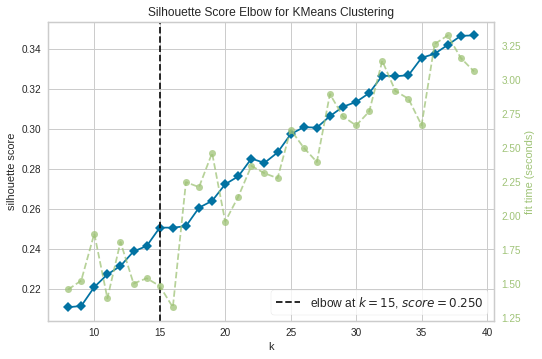

In [15]:
# select second elbow
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=7777)
visualizer = KElbowVisualizer(model, k=(8,40), metric="silhouette")
visualizer.fit(tfidf_matrix)
visualizer.show()

In [16]:
model = KMeans(n_clusters=20, random_state=7777)
cluster_res = model.fit_predict(tfidf_matrix)
for idx, res in enumerate(cluster_res):
    label[unknown_label[idx]] = res

In [17]:
mapping = dict()
index = 20
for key in PRODUCT_WORD.keys():
    mapping[key] = index
    index += 1
for idx, cat in enumerate(label):
    if isinstance(cat, str):
        label[idx] = mapping[cat]
metadata_processed['category'] = pd.Series(label)
print(len(label), len(metadata_processed))
print(metadata_processed['text_data'].isnull().sum())

31901 31901
0


In [18]:
print(metadata_processed['category'].value_counts())
print(mapping)

2.0     7637
21.0    3186
24.0    1627
22.0    1028
29.0     896
38.0     851
26.0     831
27.0     737
20.0     695
40.0     637
25.0     619
41.0     611
34.0     594
44.0     534
4.0      520
23.0     476
31.0     474
19.0     449
7.0      444
46.0     424
11.0     415
1.0      415
33.0     397
51.0     364
47.0     346
30.0     318
16.0     317
54.0     290
10.0     287
9.0      257
28.0     255
17.0     254
42.0     252
45.0     232
8.0      223
39.0     215
53.0     214
3.0      211
18.0     206
12.0     180
43.0     171
37.0     171
48.0     165
5.0      165
50.0     155
6.0      142
13.0     140
32.0     137
36.0     137
0.0      135
15.0     128
49.0     126
14.0     123
35.0     105
Name: category, dtype: int64
{'soap': 20, 'hair': 21, 'cream': 22, 'shampoo': 23, 'nail': 24, 'brush': 25, 'lip': 26, 'fragrance': 27, 'vitamin': 28, 'spray': 29, 'ring': 30, 'clean': 31, 'nose': 32, 'jewelry': 33, 'powder': 34, 'razor': 35, 'shave': 36, 'acid': 37, 'eye': 38, 'ear': 39, 'moisture

In [19]:
for i in range(21):
    tf_dict = dict()
    for idx, sent in enumerate(title_without_brand):
        if label[idx]==i:
            title = list()
            for word in sent:
                if  (not((word.norm_ in stop_word) or (word.is_punct) or (word.is_digit))) and len(word)>=2:
                    title.append(word.norm_)
            gram = [' '.join(item) for item in list(ngrams(title, 1))]
            tf_dict = count_tf(gram, tf_dict)
    tf_dict = sorted(tf_dict.items(), key=lambda value:value[1], reverse=True)
    print(f'cluster {i}: ')
    print(tf_dict[:40])
    print('='*50)

cluster 0: 
[('bottle', 171), ('bottles', 34), ('glass', 22), ('clear', 16), ('essential', 16), ('cap', 16), ('pump', 13), ('amber', 12), ('alcohol', 12), ('plastic', 11), ('water', 10), ('secret', 10), ('travel', 10), ('1/2', 9), ('tablets', 9), ('easy', 9), ('yin', 8), ('reducer', 8), ('pills', 7), ('applicator', 7), ('soft', 7), ('india', 7), ('tip', 7), ('bpa', 6), ('convenient', 6), ('invisible', 6), ('scent', 6), ('roll', 6), ('item', 6), ('pure', 6), ('dispensing', 6), ('lid', 6), ('round', 6), ('ball', 6), ('fiesta', 6), ('orifice', 6), ('atomizer', 5), ('standard', 5), ('5ml', 5), ('2.6-ounce', 5)]
cluster 1: 
[('body', 675), ('wash', 85), ('skin', 75), ('butter', 59), ('massage', 50), ('face', 37), ('wrap', 32), ('waist', 31), ('scrub', 29), ('mist', 28), ('resistance', 27), ('water', 25), ('soft', 25), ('cellulite', 25), ('chair', 24), ('works', 22), ('energy', 22), ('spa', 21), ('cool', 21), ('coconut', 20), ('exercise', 19), ('system', 19), ('easy', 19), ('fresh', 19), ('h

In [20]:
def transform(data):
    res = dict()
    for item, row in data.iterrows():
        res[row['asin']] = row['category']
    return res

def construct(data):
    if cluster_dict.get(data):
        return cluster_dict[data]
    else:
        return 60.0
metadata_processed['category'] = pd.Series(label)
cluster_dict = transform(metadata_processed)
ratings['category'] = ratings['asin'].apply(construct)

In [21]:
print(ratings['category'].value_counts())

2.0     81237
60.0    37759
21.0    32462
28.0    15923
24.0    14761
22.0    12666
26.0    11920
23.0     7829
29.0     7403
38.0     6957
27.0     6864
46.0     6396
25.0     6257
40.0     5713
20.0     5698
41.0     5682
51.0     5258
44.0     5052
1.0      5037
4.0      4768
7.0      4068
31.0     4054
34.0     3993
30.0     3808
19.0     3731
47.0     3539
54.0     3305
42.0     3275
10.0     3118
33.0     3108
11.0     3043
17.0     2617
45.0     2462
36.0     2438
12.0     2385
8.0      2383
5.0      2369
53.0     2363
16.0     2110
35.0     2005
9.0      1935
3.0      1772
43.0     1760
15.0     1453
37.0     1449
6.0      1419
18.0     1351
14.0     1289
32.0     1258
39.0     1231
50.0     1116
48.0     1023
13.0      997
49.0      989
Name: category, dtype: int64


## 資料切分

In [22]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

# 產生推薦

In [23]:
from itertools import combinations
from collections import defaultdict
import pandas as pd
from itertools import combinations
from collections import defaultdict

def my_recommender(training_data, time, category, users=[], k=10, debug=True):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating
    if debug:
        print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating
    if debug:
        print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy
    if debug:
        print("sim data prepared")
    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order
    cold_start = training_data[
        (training_data['DATE']>=time)&
        (training_data['overall']>=4)&
        (training_data['category'].isin(category))
    ]
    cold_start = cold_start['asin'].value_counts().sort_values(ascending=False).keys()[:k].to_list()
    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k*5:
                        stop = True
                        break
                if stop:
                    break
        if len(items) == 0:
            recommendation[user] = cold_start
        else:
            category_list = [ratings_trainings[ratings_trainings['asin']==target].category.to_list()[0] for target in items]
            category_list = pd.DataFrame({'label': category_list}).groupby('label').size().nlargest(10).index[:3].to_list()
            target_list = training_data[
                (training_data['DATE']>=time)&
                (training_data['overall']>=4)&
                (training_data['category'].isin(category_list))
            ]
            target_list = target_list['asin'].value_counts().sort_values(ascending=False).keys()[:k].to_list()
            if debug:
                print(f"User: {user}, recommend category in {category_list}'s items")
            recommendation[user] = target_list
    return recommendation

## 結果評估

## baseline

In [24]:
def recommender(training_data, time, category, users=[], k=10):

    target_list = training_data[
                (training_data['DATE']>=time)&
                (training_data['overall']>=4)&
                (training_data['category'].isin(category))
            ]
    target_list = target_list['asin'].value_counts().sort_values(ascending=False).keys()[:k].to_list()
    recommendations = {user: target_list for user in users}
    return recommendations

def evaluate(ratings_testings_by_user, ratings_by_user, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
    score = total / len(ratings_testings)
    return score

time_list = ['2018-07-01','2018-05-01', '2018-01-01', '2016-01-01']
category = [2, 26, 28]
for time in time_list:
    ratings_by_user = recommender(ratings_trainings, time, category, users, k=10)
    score = evaluate(ratings_testings_by_user, ratings_by_user)
    print(f'{time}, score: {score}')

2018-07-01, score: 0.1711864406779661
2018-05-01, score: 0.15254237288135594
2018-01-01, score: 0.1288135593220339
2016-01-01, score: 0.09830508474576272


## method 1

In [25]:
time_list = ['2018-07-01','2018-05-01', '2018-01-01', '2016-01-01']
category = [2, 26, 28]
score_list = list()
for time in time_list:
    ratings_by_user = my_recommender(ratings_trainings, time, category, users, k=10, debug=True)
    score = evaluate(ratings_testings_by_user, ratings_by_user)
    score_list.append(score)
for idx, time in enumerate(time_list):
    print(f'{time}, score: {score_list[idx]}')

data converted
data inverted
sim data prepared
User: A13JU88JAHN72I, recommend category in [60.0]'s items
User: A16Y7V1CZCWKFV, recommend category in [2.0, 21.0, 40.0]'s items
User: A19503XX7GU6J2, recommend category in [2.0, 21.0, 22.0]'s items
User: A1EY751AUVO5NZ, recommend category in [3.0, 5.0, 7.0]'s items
User: A1PR178735XC70, recommend category in [21.0, 2.0, 31.0]'s items
User: A1SA3N793WT2LM, recommend category in [2.0, 21.0, 60.0]'s items
User: A1TP9JHTIY468V, recommend category in [2.0, 24.0, 34.0]'s items
User: A1WEFBEJ7OHSVZ, recommend category in [2.0, 34.0, 60.0]'s items
User: A1WSZED2O5MA5T, recommend category in [2.0, 60.0, 21.0]'s items
User: A28E3FNV1BYC94, recommend category in [2.0, 21.0, 24.0]'s items
User: A29834GBB4DOP1, recommend category in [60.0, 24.0, 26.0]'s items
User: A2AAQWBJJTK3E1, recommend category in [2.0]'s items
User: A2BU6N5956T9NH, recommend category in [60.0, 2.0, 21.0]'s items
User: A2IMJV0CQMZLGC, recommend category in [2.0, 20.0, 29.0]'s ite

In [26]:
32

32